In [1]:
import yahoo_fin.stock_info as si
import pandas as pd

In [13]:
#Nasdaq: tickers_nasdaq()
#S&P500: tickers_sp500()
#Others: tickers_other()
nasdaq = si.tickers_nasdaq()

In [14]:
import requests
import json
def callApi(url, stock):

    querystring = {"symbol": stock }

    headers = {
        'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
        'x-rapidapi-key': "b057006049msh2dd6f48e0283787p151e0djsnf76cd322583c"
        }

    response = requests.request("GET", url, headers=headers, params=querystring)
    balance_sheet = json.loads(response.text)
    return balance_sheet

In [81]:
def priceToBook(stocks):
    for stock in stocks:
        result = callApi("https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-summary", stock)
        if "raw" in result["defaultKeyStatistics"]["priceToBook"].keys():
            return  result["defaultKeyStatistics"]["priceToBook"]["raw"]
        else:
            return 0.0

In [33]:
#P/E Ratio= Earnings per Share / Price per Share

sp500 =['LUV']
dow_stats = {}
priceBook = {} 
for ticker in sp500:
    price_Book = priceToBook(ticker)
    temp = si.get_stats_valuation(ticker)
    print(price_Book)
    temp = temp.iloc[:,:2]
    print(temp)
    temp.columns = ["Attribute", "Recent"]
    dow_stats[ticker] = temp
    priceBook[ticker] = price_Book

    
combined_stats = pd.concat(dow_stats)
combined_stats = combined_stats.reset_index()
del combined_stats["level_1"]
# update column names
combined_stats.columns = ["Ticker", "Attribute", "Recent"]
pe_ratios = combined_stats[combined_stats["Attribute"]=="Trailing P/E"].reset_index()
pe_ratios

0.6018322
                    Unnamed: 0 As of Date: 8/28/2020Current
0      Market Cap (intraday) 5                       22.21B
1           Enterprise Value 3                       19.17B
2                 Trailing P/E                       110.74
3                Forward P/E 1                         9.90
4  PEG Ratio (5 yr expected) 1                         1.64
5            Price/Sales (ttm)                         1.21
6             Price/Book (mrq)                         2.04
7   Enterprise Value/Revenue 3                         1.15
8    Enterprise Value/EBITDA 6                        12.81
{'LUV':                      Attribute  Recent
0      Market Cap (intraday) 5  22.21B
1           Enterprise Value 3  19.17B
2                 Trailing P/E  110.74
3                Forward P/E 1    9.90
4  PEG Ratio (5 yr expected) 1    1.64
5            Price/Sales (ttm)    1.21
6             Price/Book (mrq)    2.04
7   Enterprise Value/Revenue 3    1.15
8    Enterprise Value/EBITDA 6 

,index,Ticker,Attribute,Recent
0,2,LUV,Trailing P/E,110.74


In [84]:
sp500 =['LUV','TELA', 'FB', 'MAR', 'JPM','HTZ', 'DAL' ]
dow_stats = {}
data = {} 
for ticker in sp500:
    data = si.get_stats_valuation(ticker)
    data = data.iloc[:,:2]
    data.columns = ["Attribute", "Recent < 15"]
    data = data[data["Attribute"]=="Trailing P/E"]
    trailing_PE = float(data["Recent < 15"])
    price_Book = priceToBook(ticker)
    data["Ticker"] = ticker
    data["price_Book < 1.5"] = price_Book
    validate = trailing_PE * price_Book
    data["validate < 22.5"] = validate
    if validate < 22.5:
        data["Need a look"] = True
    else: 
        data["Need a look"] = False
    print(data)

      Attribute Recent < 15 Ticker  price_Book < 1.5  validate < 22.5  \
2  Trailing P/E      110.74    LUV          0.601832        66.646898   

   Need a look  
2        False  
      Attribute Recent < 15 Ticker  price_Book < 1.5  validate < 22.5  \
2  Trailing P/E         NaN   TELA          1.216884              NaN   

   Need a look  
2        False  
      Attribute Recent < 15 Ticker  price_Book < 1.5  validate < 22.5  \
2  Trailing P/E       35.85     FB          0.895715        32.111383   

   Need a look  
2        False  
      Attribute Recent < 15 Ticker  price_Book < 1.5  validate < 22.5  \
2  Trailing P/E       73.76    MAR          0.799494        58.970666   

   Need a look  
2        False  
      Attribute Recent < 15 Ticker  price_Book < 1.5  validate < 22.5  \
2  Trailing P/E       13.78    JPM               0.0              0.0   

   Need a look  
2         True  
      Attribute Recent < 15 Ticker  price_Book < 1.5  validate < 22.5  \
2  Trailing P/E       

In [78]:
priceToBook('JPM')

10000.0

In [82]:
import seaborn as sea

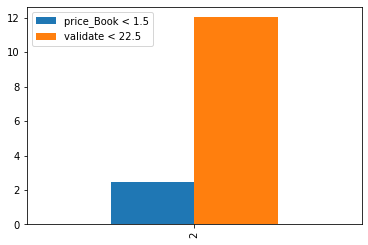

In [83]:
data.plot(kind = 'bar')